In [763]:
import pandas as pd
import numpy as np

# For later steps (not used yet, but standard to import early)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_csv("data/players_season_stats.csv")

# Basic inspection
print(df.shape)
df.head()


(549, 12)


,player_id,player_name,position_name,season,events,passes,shots,carries,pressures,goals,xg,assists
0,3064,David Josué Jiménez Silva,Center Attacking Midfield,2015/2016,5147,1488,29,1301,326,2,2.835009,10
1,3652,Tom Davies,Center Attacking Midfield,2015/2016,199,49,1,47,25,0,0.042698,0
2,19688,Jason Puncheon,Center Attacking Midfield,2015/2016,5345,1408,53,1226,576,2,3.575957,3
3,9528,Steven Naismith,Center Attacking Midfield,2015/2016,2473,506,26,423,296,4,3.209565,2
4,4738,Lee Tomlin,Center Attacking Midfield,2015/2016,559,122,4,115,80,0,0.224499,0


In [764]:
df["position_name"].value_counts()

position_name
Center Forward               65
Right Back                   52
Goalkeeper                   47
Left Back                    46
Right Center Back            43
Left Wing                    37
Right Wing                   37
Left Center Back             36
Center Attacking Midfield    31
Right Center Midfield        28
Left Defensive Midfield      24
Left Center Midfield         22
Right Defensive Midfield     22
Left Midfield                19
Right Midfield               18
Center Defensive Midfield    10
Right Center Forward          5
Left Center Forward           5
Right Attacking Midfield      1
Right Wing Back               1
Name: count, dtype: int64

In [765]:
df_filtered = df.copy()

positions_to_exclude = [
    "Goalkeeper",
    "Right Back",
    "Left Back",
    "Right Center Back",
    "Left Center Back",
    "Right Wing Back"
]

# Filter
df_filtered = df_filtered[
    ~df_filtered["position_name"].isin(positions_to_exclude)
]


min_events = 150
df_filtered = df_filtered[df_filtered["events"] >= min_events]


# Sanity checks
print("Original players:", df.shape[0])
print("After filtering:", df_filtered.shape[0])
df_filtered["position_name"].value_counts()


Original players: 549
After filtering: 278


position_name
Center Forward               57
Left Wing                    34
Right Wing                   31
Center Attacking Midfield    28
Left Defensive Midfield      23
Right Center Midfield        22
Left Center Midfield         20
Right Defensive Midfield     20
Left Midfield                14
Right Midfield               12
Center Defensive Midfield     9
Right Center Forward          5
Left Center Forward           3
Name: count, dtype: int64

In [766]:
df_features = df_filtered.copy()

# Avoid division by zero by replacing 0 with NaN temporarily
df_features[["events", "shots", "passes"]] = df_features[
    ["events", "shots", "passes"]
].replace(0, np.nan)

# Create ratio-based features
df_features["pass_ratio"] = df_features["passes"] / df_features["events"]
df_features["shot_ratio"] = df_features["shots"] / df_features["events"]
df_features["carry_ratio"] = df_features["carries"] / df_features["events"]
df_features["pressure_ratio"] = df_features["pressures"] / df_features["events"]

df_features["goal_conversion"] = df_features["goals"] / df_features["shots"]
df_features["xg_per_shot"] = df_features["xg"] / df_features["shots"]
df_features["assist_ratio"] = df_features["assists"] / df_features["passes"]

# Replace NaN back with 0 (players with no shots, passes, etc.)
df_features = df_features.fillna(0)

#df_features.head()

In [767]:
# Select features for clustering
feature_cols = [
    "pass_ratio",
    "shot_ratio",
    "carry_ratio",
    "pressure_ratio",
    "goal_conversion",
    "xg_per_shot",
    "assist_ratio",
]

X = df_features[feature_cols]

# Scale features
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled = pd.DataFrame(
    X_scaled_array,
    columns=feature_cols,
    index=X.index
)

# Inspect
X_scaled.head()

,pass_ratio,shot_ratio,carry_ratio,pressure_ratio,goal_conversion,xg_per_shot,assist_ratio
0,1.051809,-0.762731,1.308156,-1.449714,-0.146371,0.127058,0.964469
1,0.205818,-0.854364,0.843179,0.677704,-1.100580,-0.908477,-0.829775
2,0.545101,-0.118757,0.652350,0.067594,-0.578465,-0.442569,-0.260918
3,-0.615546,-0.028852,-0.982610,0.474988,1.028041,0.610132,0.225496
4,-0.346429,-0.533915,-0.010558,1.274859,-1.100580,-0.655955,-0.829775


c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_

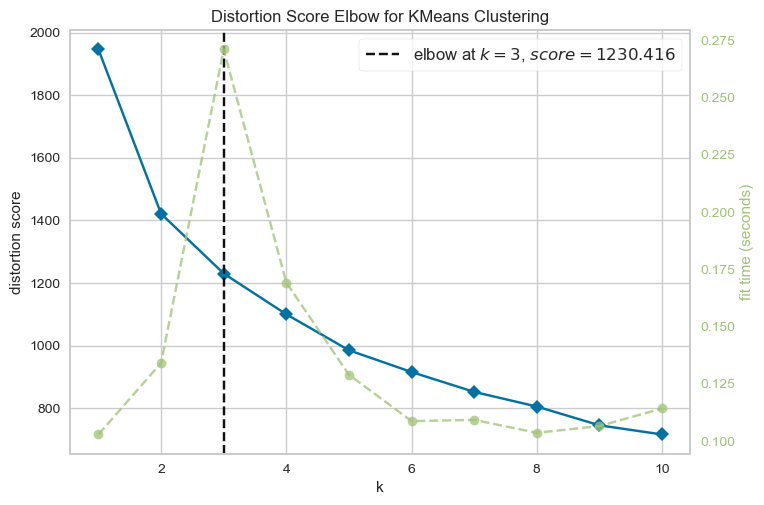

In [768]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0, n_init=10)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(X_scaled)
_ = visualizer.show()

In [769]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(3, 11):
    labels = KMeans(n_clusters=k, random_state=0).fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

for k, score in zip(range(3, 11), sil_scores):
    print(f"k={k}: silhouette={score:.3f}")


c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_

k=3: silhouette=0.211
k=4: silhouette=0.197
k=5: silhouette=0.176
k=6: silhouette=0.183
k=7: silhouette=0.180
k=8: silhouette=0.135
k=9: silhouette=0.159
k=10: silhouette=0.150


c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [770]:
# Number of clusters
k = 3

# Fit final K-Means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_features["cluster"] = kmeans.fit_predict(X_scaled)

# Quick check
df_features["cluster"].value_counts()

c:\Users\nirag\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


cluster
1    112
2     91
0     75
Name: count, dtype: int64

In [771]:
# Features used in clustering
cluster_features = feature_cols

# Average feature values per cluster
cluster_profiles = (
    df_features
    .groupby("cluster")[cluster_features]
    .mean()
)

cluster_profiles

,pass_ratio,shot_ratio,carry_ratio,pressure_ratio,goal_conversion,xg_per_shot,assist_ratio
cluster,,,,,,,
0,0.176815,0.017804,0.165603,0.107923,0.121661,0.132950,0.003373
1,0.276711,0.005849,0.213192,0.113345,0.031515,0.062201,0.001098
2,0.234067,0.010832,0.230752,0.094719,0.103947,0.091881,0.005363


In [772]:
# Raw features (initial stats)
raw_cluster_features = [
    "events",
    "passes",
    "shots",
    "carries",
    "pressures",
    "goals",
    "xg",
    "assists"
]

# Average raw feature values per cluster
cluster_raw_profiles = (
    df_features
    .groupby("cluster")[raw_cluster_features]
    .mean()
)

cluster_raw_profiles


,events,passes,shots,carries,pressures,goals,xg,assists
cluster,,,,,,,,
0,2170.040000,391.306667,39.626667,365.520000,225.773333,5.493333,5.312188,1.546667
1,2935.696429,837.625000,16.633929,641.625000,321.455357,0.758929,1.074803,1.125000
2,3364.934066,825.615385,35.703297,781.494505,298.406593,3.923077,3.374579,3.758242


In [773]:
# Columns to export
export_cols = [
    "cluster",
    "player_name",
    "position_name",
    "events",
    "passes",
    "shots",
    "carries",
    "pressures",
    "goals",
    "xg",
    "assists"
] + feature_cols

# Export to CSV
df_features.sort_values("cluster")[export_cols] \
    .to_csv("players_by_cluster_with_stats.csv", index=False)


In [774]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["cluster"] = df_features["cluster"].values



In [775]:
pca.explained_variance_ratio_.sum()

np.float64(0.5938786614325079)

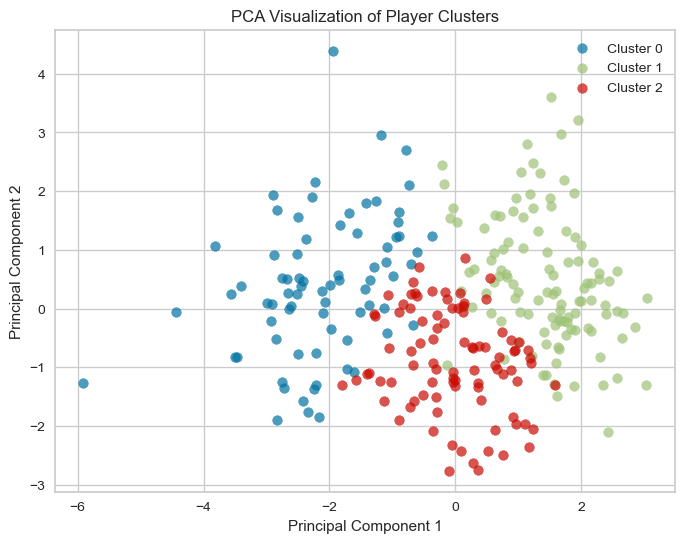

In [776]:
# Plot
plt.figure(figsize=(8, 6))
for c in sorted(pca_df["cluster"].unique()):
    subset = pca_df[pca_df["cluster"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {c}", alpha=0.7)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.title("PCA Visualization of Player Clusters")
plt.show()

In [777]:
# Count players per position and cluster
position_cluster_counts = (
    df_features
    .groupby(["position_name", "cluster"])
    .size()
    .unstack(fill_value=0)
)

# Convert counts to percentages per position
position_cluster_pct = position_cluster_counts.div(
    position_cluster_counts.sum(axis=1),
    axis=0
).mul(100)

position_cluster_pct


cluster,0,1,2
position_name,,,
Center Attacking Midfield,3.571429,28.571429,67.857143
Center Defensive Midfield,0.000000,100.000000,0.000000
Center Forward,92.982456,5.263158,1.754386
Left Center Forward,100.000000,0.000000,0.000000
Left Center Midfield,0.000000,80.000000,20.000000
Left Defensive Midfield,0.000000,86.956522,13.043478
Left Midfield,7.142857,35.714286,57.142857
Left Wing,20.588235,17.647059,61.764706
Right Center Forward,100.000000,0.000000,0.000000


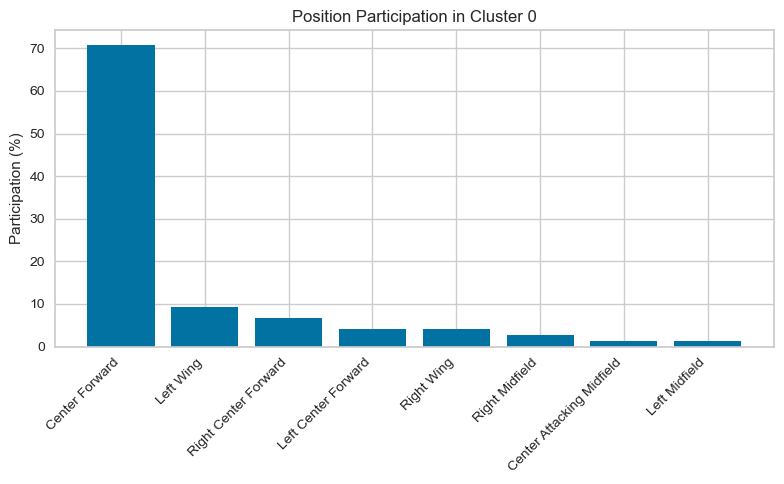

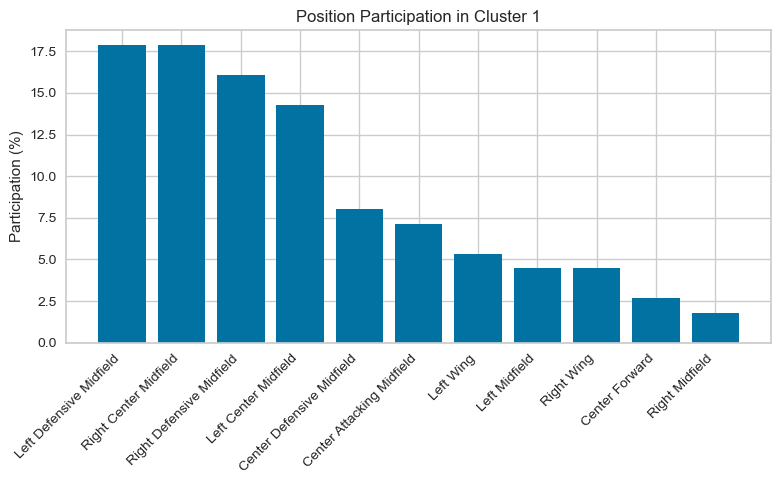

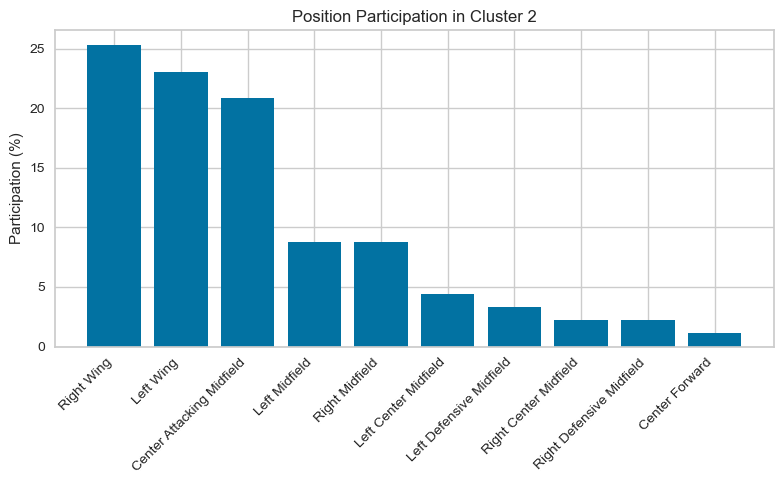

In [778]:
import matplotlib.pyplot as plt

# Compute counts
cluster_position_counts = (
    df_features
    .groupby(["cluster", "position_name"])
    .size()
    .reset_index(name="count")
)

# Compute percentages within each cluster
cluster_totals = cluster_position_counts.groupby("cluster")["count"].transform("sum")
cluster_position_counts["percentage"] = (
    cluster_position_counts["count"] / cluster_totals * 100
)

# Plot one chart per cluster
clusters = sorted(cluster_position_counts["cluster"].unique())
for c in clusters:
    subset = (
        cluster_position_counts[cluster_position_counts["cluster"] == c]
        .sort_values("percentage", ascending=False)
    )
    plt.figure(figsize=(8, 5))
    plt.bar(subset["position_name"], subset["percentage"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Participation (%)")
    plt.title(f"Position Participation in Cluster {c}")
    plt.tight_layout()
    plt.show()
